In [1]:
import pandas as pd
import nilmtk
import matplotlib.pyplot as plt
import random
import sys
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import h5py
from nilmtk import DataSet
from nilmtk.utils import print_dict
from nilmtk.datastore import HDFDataStore
from matplotlib import rcParams
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from S2P import ShortSeq2PointDisaggregator
import time
import metrics

In [2]:
print("========== OPEN DATASETS ============")
# train_house02 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
# train_house03 = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
# train_house02.set_window(end="5-2-2011")
# train_house03.set_window(end="28-4-2011")

test = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
test.set_window(start="5-9-2011")

train = DataSet('E:\\Project\\python\\NILM-Final\\redd_low_new.h5')
train.set_window(end="5-2-2011")

train_building = [1]
test_building = 1
sample_period = 3
meter_key = 'fridge'


train_mains = train.buildings[1].elec.mains().all_meters()[0]
train_meters = train.buildings[train_building[0]].elec.submeters()[meter_key]

test_mains = test.buildings[test_building].elec.mains().all_meters()[0]
test_meters = test.buildings[test_building].elec.submeters()[meter_key]

rnn = ShortSeq2PointDisaggregator(window_size=20)

========== OPEN DATASETS ============
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 30)            330       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 30)            7230      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 40)            7240      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 20, 50)            10050     
_________________________________________________________________
dropout (Dropout)            (None, 20, 50)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 20, 50)            12550     
_________________________________________________________________
dropout_1 (Dropout

In [3]:
start = time.time()
print("========== TRAIN ============")

history = rnn.train(train_mains, train_meters, epochs=30,sample_period=sample_period)
rnn.export_model("model_Single-Fridge-CNN000.h5")

end = time.time()
print("Train =", end-start, "seconds.")

========== TRAIN ============
(391937, 20, 1)
(391937,)
364.28488
136.06915
221.91333
17.104923
128
Epoch 1/30
2450/2450 [==============================] - 40s 10ms/step - loss: 0.4298 - val_loss: 0.4575
Epoch 2/30
2450/2450 [==============================] - 27s 11ms/step - loss: 0.2903 - val_loss: 0.3076
Epoch 3/30
2450/2450 [==============================] - 25s 10ms/step - loss: 0.1918 - val_loss: 0.2472
Epoch 4/30
2450/2450 [==============================] - 25s 10ms/step - loss: 0.1631 - val_loss: 0.2288
Epoch 5/30
2450/2450 [==============================] - 25s 10ms/step - loss: 0.1551 - val_loss: 0.2236
Epoch 6/30
2450/2450 [==============================] - 25s 10ms/step - loss: 0.1517 - val_loss: 0.2214
Epoch 7/30
2450/2450 [==============================] - 26s 11ms/step - loss: 0.1488 - val_loss: 0.2188
Epoch 8/30
2450/2450 [==============================] - 26s 11ms/step - loss: 0.1468 - val_loss: 0.2174
Epoch 9/30
2450/2450 [==============================] - 25s 10ms/ste

In [5]:
print("========== DISAGGREGATE ============")
disag_filename = 'disag_Single-Fridge-CNN000.h5'
output = HDFDataStore(disag_filename, 'w')
rnn.disaggregate(test_mains, output, train_meters, sample_period=sample_period)
output.close()

========== DISAGGREGATE ============
New sensible chunk: 46179
New sensible chunk: 10838
New sensible chunk: 9086
New sensible chunk: 11612
New sensible chunk: 33611
New sensible chunk: 30


========== Plot ============


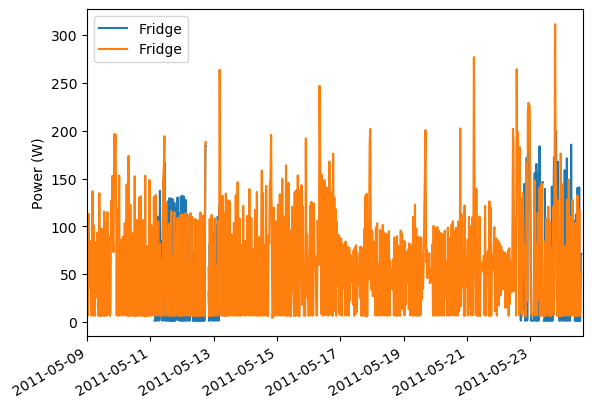

In [6]:
result = DataSet(disag_filename)
res_elec = result.buildings[test_building].elec

print("========== Plot ============")

predicted = res_elec[meter_key]
ground_truth = test_meters
import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
# ground_truth.plot(timeframe=good_sections_pre[2])
# ground_truth.plot(timeframe=good_sections_pre[0])
# plt.savefig('pre.jpg',dpi=300)
plt.show()

In [7]:
good_sections_pre = predicted.good_sections()
good_sections_pre

[TimeFrame(start='2011-05-11 03:20:39-04:00', end='2011-05-12 17:48:36-04:00', empty=False),
 TimeFrame(start='2011-05-12 20:15:27-04:00', end='2011-05-13 05:16:21-04:00', empty=False),
 TimeFrame(start='2011-05-22 16:05:42-04:00', end='2011-05-22 23:39:00-04:00', empty=False),
 TimeFrame(start='2011-05-22 23:42:30-04:00', end='2011-05-23 09:22:06-04:00', empty=False),
 TimeFrame(start='2011-05-23 10:32:30-04:00', end='2011-05-24 14:32:03-04:00', empty=False),
 TimeFrame(start='2011-05-24 15:56:30-04:00', end='2011-05-24 15:57:00-04:00', empty=False)]

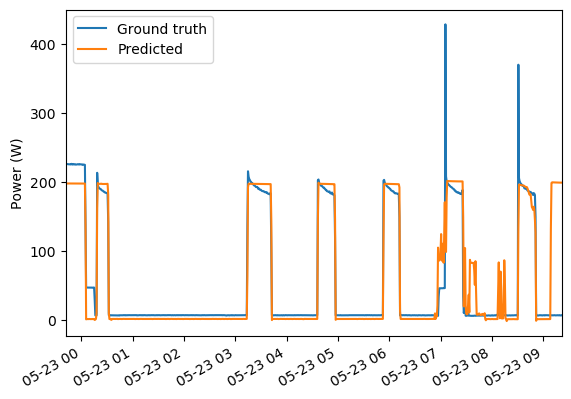

In [8]:
ground_truth.plot(timeframe=good_sections_pre[3])
predicted.plot(timeframe=good_sections_pre[3])
plt.legend(['Ground truth', 'Predicted'])
plt.show()

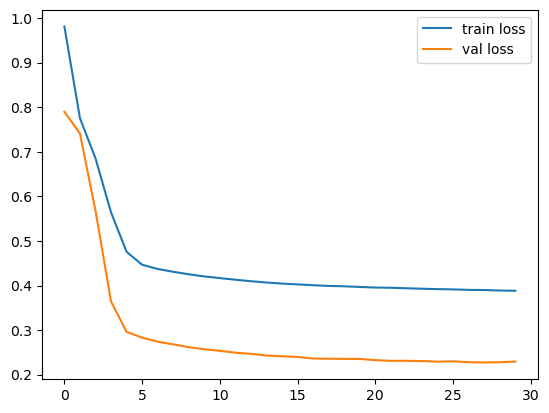

In [9]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()

In [10]:
print("========== RESULTS ============")
result = DataSet('disag_Single-Fridge-CNN.h5')
res_elec = result.buildings[test_building].elec
rpaf = metrics.recall_precision_accuracy_f1(res_elec[meter_key], test_meters)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(res_elec[meter_key], test_meters)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(res_elec[meter_key], test_meters)))

========== RESULTS ============
============ Recall: 0.6853340726365401
============ Precision: 0.861881755242317
============ Accuracy: 0.8024695908588279
============ F1 Score: 0.7635352777655209
============ Relative error in total energy: 0.21091011582389035
============ Mean absolute error(in Watts): 28.42755546713831
